In [2]:
%matplotlib widget
import torch
import os
import copy
import subprocess
import shlex

os.environ['TORCH_CUDA_ARCH_LIST'] = f'{torch.cuda.get_device_properties(0).major}.{torch.cuda.get_device_properties(0).minor}'

import warnings
from tqdm import TqdmExperimentalWarning
warnings.filterwarnings("ignore", category=TqdmExperimentalWarning)
from tqdm.autonotebook import tqdm
import matplotlib.pyplot as plt

from sphMath.sampling import buildDomainDescription
from sphMath.modules.adaptiveSmoothingASPH import n_h_to_nH
from sphMath.plotting import visualizeParticles, updatePlot
from sphMath.integration import getIntegrator
from sphMath.util import volumeToSupport
from sphMath.boundary import sampleDomainSDF
from sphMath.kernels import getKernelEnum
from sphMath.sdf import getSDF, sdfFunctions, operatorDict, sampleSDF
from sphMath.regions import buildRegion, filterRegion, plotRegions
from sphMath.modules.timestep import computeTimestep
# from sphMath.schemes.weaklyCompressible import updateBodyParticles, initializeWeaklyCompressibleSimulation
from sphMath.schemes.initializers import initializeSimulation, updateBodyParticles
from sphMath.schemes.deltaSPH import deltaPlusSPHScheme, DeltaPlusSPHSystem
from torch.profiler import profile,  ProfilerActivity
from sphMath.schema import getSimulationScheme
from sphMath.enums import *

In [13]:
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')
# device = torch.device('cpu')
dtype = torch.float32

nx = 64
L = 2
dim = 2
kernel = KernelType.Wendland4
targetNeighbors = n_h_to_nH(4,dim)
CFL = 0.3

scheme = SimulationScheme.DeltaSPH
integrationScheme = IntegrationSchemeType.symplecticEuler
dx = L / nx
band = 5

domain = buildDomainDescription(l = L + dx * (band) * 2, dim = dim, periodic = True, device = device, dtype = dtype)
interiorDomain = buildDomainDescription(l = L, dim = dim, periodic = False, device = device, dtype = dtype)
wrappedKernel = kernel

simulator, SimulationSystem, config, integrator = getSimulationScheme(
     scheme, kernel, integrationScheme, 
     1.0, targetNeighbors, domain)
integrationScheme = getIntegrator(integrationScheme)

config = {
    'domain': domain,
    'kernel': wrappedKernel,
    'verletScale': 1.4,
    'neighborhood': {'verletScale': 1.4},
    'shifting': {'scheme': 'delta', 'freeSurface': False},
    'surfaceDetection': {'active': False},
    'pressure':{'term': 'nonConservative'},
    'fluid': {'rho0': 1, 'c_s': 20},    
    'gravity': {'active': False, 'magnitude': 1, 'mode': 'potential'},
    'particle': {'nx': nx, 'dx': L/nx, 'targetNeighbors': targetNeighbors, 'band': band, 'support': volumeToSupport((L/nx)**dim, targetNeighbors, dim)},
    'timestep':{'CFL': CFL, 'dt': 1e-3, 'maxDt': 1e-2, 'minDt': 1e-6},
    'scheme': scheme
}
# config['particle'] = {
#     'nx': nx + 2 * band,
#     'dx': L/nx,
#     'targetNeighbors': targetNeighbors,
#     'band': band
# }
# config['fluid'] = {
#     'rho0': 1,
#     'c_s': 20
# }
# display(config)

In [14]:

# display(config)

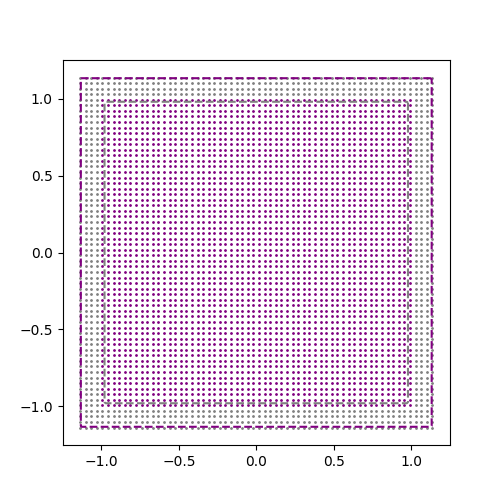

In [15]:
fluid_sdf = lambda x: sampleDomainSDF(x, domain, invert = True)
domain_sdf = lambda x: sampleDomainSDF(x, interiorDomain, invert = False)
obstacle_sdf = lambda points: sampleSDF(points, lambda x: getSDF('circle')['function'](x, torch.tensor(1/4).to(points.device)), invert = False)

box_sdf = lambda points: sampleSDF(points, lambda x: getSDF('box')['function'](x, torch.tensor([0.5,0.5]).to(points.device)))

inlet_sdf = lambda points: sampleSDF(points, operatorDict['translate'](lambda x: getSDF('box')['function'](x, torch.tensor([0.125,0.125]).to(points.device)), torch.tensor([-0.5,0.5]).to(points.device)), invert = False)
outlet_sdf = lambda points: sampleSDF(points, operatorDict['translate'](lambda x: getSDF('box')['function'](x, torch.tensor([0.125,0.125]).to(points.device)), torch.tensor([0.5,-0.5]).to(points.device)), invert = False)
outletBuffer_sdf = lambda points: sampleSDF(points, operatorDict['translate'](lambda x: getSDF('box')['function'](x, torch.tensor([0.25,0.25]).to(points.device)), torch.tensor([0.5,-0.5]).to(points.device)), invert = False)


regions = []

regions.append(buildRegion(sdf = domain_sdf, config = config, type = 'boundary', kind = 'constant'))
# regions.append(buildRegion(sdf = obstacle_sdf, config = config, type = 'boundary', kind = 'zero'))
regions.append(buildRegion(sdf = fluid_sdf, config = config, type = 'fluid'))
# regions.append(buildRegion(sdf = inlet_sdf, config = config, type = 'inlet', dirichletValues={'densities': config['fluid']['rho0'], 'velocities': torch.tensor([1,0], device = device, dtype = dtype)}, updateValues = {'densities': 0, 'velocities': torch.tensor([0,0], device = device, dtype = dtype)}))

# regions.append(buildRegion(sdf = outlet_sdf, config = config, type = 'outlet'))
# regions.append(buildRegion(sdf = outletBuffer_sdf, config = config, type = 'buffer', bufferValues = ['densities', 'velocities', 'pressures']))

# regions.append(buildRegion(sdf = box_sdf, config = config, type = 'dirichlet', dirichletValues={'densities': 2.0, 'velocities': torch.tensor([1,2], device = device, dtype = dtype), 'pressures': lambda x: torch.where(x[:,0] > 0, 0.0, 1.0)}, updateValues = {'densities': 2.0}))


for region in regions:
    region = filterRegion(region, regions)


fig, axis = plt.subplots(1, 1, figsize=(5, 5), squeeze=False)
    
plotRegions(regions, axis[0,0], plotFluid = True, plotParticles = True)


In [16]:
print(regions)

[{'sdf': <function <lambda> at 0x7f1df007d800>, 'type': 'boundary', 'dirichlet': {}, 'dirichletUpdate': {}, 'bufferValues': [], 'kind': 'constant', 'initialConditions': {}, 'particles': ParticleSet(positions=tensor([[-1.1382, -1.1382],
        [-1.1382, -1.1021],
        [-1.1382, -1.0659],
        ...,
        [ 1.1382,  1.0659],
        [ 1.1382,  1.1021],
        [ 1.1382,  1.1382]], device='cuda:0'), supports=tensor([0.1445, 0.1445, 0.1445, 0.1445, 0.1445, 0.1445, 0.1445, 0.1445, 0.1445,
        0.1445, 0.1445, 0.1445, 0.1445, 0.1445, 0.1445, 0.1445, 0.1445, 0.1445,
        0.1445, 0.1445, 0.1445, 0.1445, 0.1445, 0.1445, 0.1445, 0.1445, 0.1445,
        0.1445, 0.1445, 0.1445, 0.1445, 0.1445, 0.1445, 0.1445, 0.1445, 0.1445,
        0.1445, 0.1445, 0.1445, 0.1445, 0.1445, 0.1445, 0.1445, 0.1445, 0.1445,
        0.1445, 0.1445, 0.1445, 0.1445, 0.1445, 0.1445, 0.1445, 0.1445, 0.1445,
        0.1445, 0.1445, 0.1445, 0.1445, 0.1445, 0.1445, 0.1445, 0.1445, 0.1445,
        0.1445, 0.1445,

In [24]:
from sphMath.sampling import sampleDivergenceFreeNoise
from sphMath.modules.particleShifting import computeShifting, solveShifting

particleState, config, rigidBodies = initializeSimulation(scheme, config, regions)

velocities = sampleDivergenceFreeNoise(particleState, domain, config, nx * 2, octaves = 3, lacunarity = 2, persistence = 0.5, baseFrequency = 1, tileable = True, kind = 'perlin', seed = 45906734)
particleState.velocities[particleState.positions[:,1] > 1.0,0] = 1

particles = copy.deepcopy(particleState)
particleSystem = DeltaPlusSPHSystem(domain, None, 0., copy.deepcopy(particleState), 'momentum', None, rigidBodies = rigidBodies, regions = config['regions'], config = config)

# for rigidBody in rigidBodies:
    # particleState = updateBodyParticles(particleState, rigidBody)
    
config['timestep'] = {'CFL': CFL, 'dt': 1e-3, 'maxDt': 1e-2, 'minDt': 1e-6}
dt = computeTimestep(scheme, 1e-2, particleSystem.systemState, config, None)
print(dt)
config['timestep']['dt'] = dt

configS = {
    'domain': domain,
    'kernel': config['kernel'],
    'neighborhood': {'verletScale': 1.4},
    'particle': {'dx': config['particle']['dx'], 'support': particles.supports.max().item()},
    'shifting': {'scheme': 'delta',
                'threshold': 5,
                'computeMach': False,
                'summationDensity': True
                }
}

kindMask = particleSystem.systemState.kinds == 0
particleSystem.systemState.positions[kindMask] += torch.randn_like(particleSystem.systemState.positions)[kindMask] * particleSystem.systemState.supports[kindMask].view(-1,1) * 0.05

for i in tqdm(range(256)):
    dx, *_ = solveShifting(particleSystem, 0.1, configS)
    particleSystem.systemState.positions[kindMask,:] += dx[kindMask,:]
    # print(torch.linalg.norm(dx, dim = -1).max().item())
    
kineticEnergy = 0.5 * particleState.densities * (particleState.velocities ** 2).sum(1)

t = 0
E_k0 = 0.5 * particleState.masses * torch.linalg.norm(particleState.velocities, dim = -1)**2
E_k = 0.5 * particleState.masses * torch.linalg.norm(particleState.velocities, dim = -1)**2

rhoMin = particleState.densities.min().detach().cpu().item() / config['fluid']['rho0']
rhoMean = particleState.densities.mean().detach().cpu().item() / config['fluid']['rho0']
rhoMax = particleState.densities.max().detach().cpu().item() / config['fluid']['rho0']


initialVelocity = particleState.velocities.clone()
initialDensities = particleState.densities.clone()

initialKineticEnergy = 0.5 * particleState.masses / config['fluid']['rho0'] * particleState.densities * torch.linalg.norm(initialVelocity, dim = -1)**2

t = 0

tensor(0.0009, device='cuda:0')


  0%|          | 0/256 [00:00<?, ?it/s]

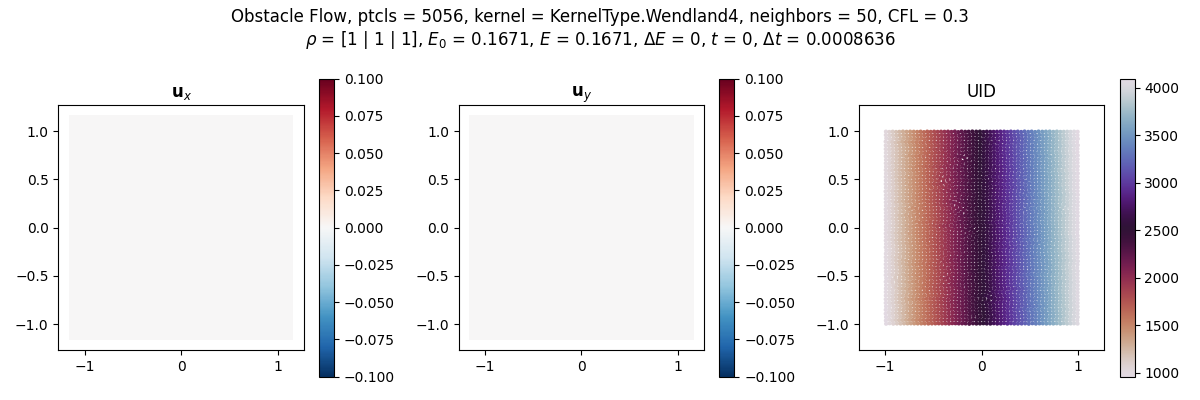

In [25]:
kineticEnergy = 0.5 * particleSystem.systemState.masses / config['fluid']['rho0'] * particleSystem.systemState.densities * torch.linalg.norm(particleSystem.systemState.velocities, dim = -1)**2

fig, axis = plt.subplots(1, 3, figsize = (12, 4), squeeze=False)

markerSize = 4
vxPlot = visualizeParticles(fig, axis[0,0], 
            particles = particleSystem.systemState, 
            domain = domain, 
            quantity = particleSystem.systemState.velocities, 
            which = 'fluid',
            mapping = '.x',
            cmap = 'RdBu_r',
            visualizeBoth=False,
            kernel = wrappedKernel,
            plotDomain = False,
            gridVisualization=True, markerSize=markerSize, streamLines=False)
# axis[0,0].set_title('Density')

vyPlot = visualizeParticles(fig, axis[0,1],
            particles = particleSystem.systemState, 
            domain = domain, 
            quantity = particleSystem.systemState.velocities, 
            which = 'both',
            # operation = 'curl',
            mapping = '.y',
            cmap = 'RdBu_r',
            visualizeBoth=False,
            kernel = wrappedKernel,
            plotDomain = False,
            gridVisualization=True, markerSize=markerSize)

uidPlot = visualizeParticles(fig, axis[0,2],
            particles = particleSystem.systemState, 
            domain = domain, 
            quantity = particleSystem.systemState.UIDs, 
            which = 'fluid',
            mapping = '.x',
            cmap = 'twilight_r',
            visualizeBoth=False,
            kernel = wrappedKernel,
            plotDomain = False,
            gridVisualization=False, markerSize=markerSize, streamLines=False)
axis[0,0].set_title(r'$\mathbf{u}_x$')
axis[0,1].set_title(r'$\mathbf{u}_y$')
axis[0,2].set_title(r'UID')


totalInitialEnergy = (initialKineticEnergy).sum().detach().cpu().item()
totalEnergy = (kineticEnergy).sum().detach().cpu().item()

fig.suptitle(f'Obstacle Flow, ptcls = {particleState.positions.shape[0]}, kernel = {kernel}, neighbors = {targetNeighbors:.2g}, CFL = {CFL}\n$\\rho$ = [{rhoMin:.4g} | {rhoMean:.4g} | {rhoMax:.4g}], $E_0$ = {totalInitialEnergy:.4g}, $E$ = {totalEnergy:.4g}, $\\Delta E$ = {totalEnergy - totalInitialEnergy:.4g}, $t$ = {t:.4g}, $\Delta t$ = {dt:.4g}')

fig.tight_layout()

In [26]:
imagePrefix = './images/LDC/'
os.makedirs(imagePrefix, exist_ok = True)

fig.savefig(f'{imagePrefix}frame_{0:05d}.png', dpi = 100)

config['diffusion'] = {'alpha': 0.1}

In [27]:
# particles = copy.deepcopy(particleState)
# particleSystem = DeltaPlusSPHSystem(domain, None, 0., copy.deepcopy(particleState), 'momentum', None, rigidBodies = rigidBodies, regions = config['regions'], config = config)

t = 0
timeLimit = 10
timesteps = int(timeLimit / dt)
plotInterval = 50

for i in (tq:=tqdm(range(timesteps))):
    particleSystem, currentState, updates = integrationScheme.function(particleSystem, dt, deltaPlusSPHScheme, config, priorStep = particleSystem.priorStep, verbose = False)
    
    if i % plotInterval == plotInterval - 1 or i == timesteps - 1:

        rhoMin = particleSystem.systemState.densities.min().detach().cpu().item() / config['fluid']['rho0']
        rhoMean = particleSystem.systemState.densities.mean().detach().cpu().item() / config['fluid']['rho0']
        rhoMax = particleSystem.systemState.densities.max().detach().cpu().item() / config['fluid']['rho0']

        kineticEnergy = 0.5 * particleSystem.systemState.masses / config['fluid']['rho0'] * particleSystem.systemState.densities * torch.linalg.norm(particleSystem.systemState.velocities, dim = -1)**2
        totalInitialEnergy = (initialKineticEnergy).sum().detach().cpu().item()
        totalEnergy = (kineticEnergy).sum().detach().cpu().item()

        fig.suptitle(f'Kolmogorov Flow, ptcls = {particleState.positions.shape[0]}, kernel = {kernel}, neighbors = {targetNeighbors:.2g}, CFL = {CFL}\n$\\rho$ = [{rhoMin:.4g} | {rhoMean:.4g} | {rhoMax:.4g}], $E_0$ = {totalInitialEnergy:.4g}, $E$ = {totalEnergy:.4g}, $\\Delta E$ = {totalEnergy - totalInitialEnergy:.4g}, $t$ = {particleSystem.t:.4g}, $\Delta t$ = {dt:.4g}')

        updatePlot(vxPlot, particleSystem.systemState, particleSystem.systemState.velocities)
        updatePlot(vyPlot, particleSystem.systemState, particleSystem.systemState.velocities)
        updatePlot(uidPlot, particleSystem.systemState, particleSystem.systemState.UIDs)

        fig.canvas.draw()
        fig.canvas.flush_events()
        fig.savefig(f'{imagePrefix}frame_{i:05d}.png', dpi = 100)
    # break
    # if i > 90:
        # break
    

  0%|          | 0/11579 [00:00<?, ?it/s]

Key delta not found in config["diffusion"]. Setting delta to 0.1
Key scheme not found in config["diffusion"]. Setting scheme to deltaSPH
Key alphaBoundary not found in config["diffusion"]. Setting alphaBoundary to 0.1


In [10]:
import subprocess
import shlex
output = 'timestamp'
scale = 1280

command = '/usr/bin/ffmpeg -loglevel warning -hide_banner -y -framerate 50 -f image2 -pattern_type glob -i '+ imagePrefix + '/frame_*.png -c:v libx264 -b:v 20M -r 50 ' + imagePrefix + '/output.mp4'
commandB = f'/usr/bin/ffmpeg -loglevel warning -hide_banner -y -i {imagePrefix}/output.mp4 -vf "fps=50,scale={scale}:-1:flags=lanczos,palettegen" {imagePrefix}/palette.png'
commandC = f'/usr/bin/ffmpeg -loglevel warning -hide_banner -y -i {imagePrefix}/output.mp4 -i {imagePrefix}/palette.png -filter_complex "fps=50,scale={scale}:-1:flags=lanczos[x];[x][1:v]paletteuse" {imagePrefix}/output.gif'

print('Creating video from  frames (frame count: {})'.format(len(os.listdir(imagePrefix))))
subprocess.run(shlex.split(command))
print('Creating gif palette')
subprocess.run(shlex.split(commandB))
print('Creating gif')
subprocess.run(shlex.split(commandC))
print('Done')


Creating video from  frames (frame count: 233)
Creating gif palette
Creating gif
Done
